In [2]:
import numpy as np
import time
import torch 
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
#print(os.listdir("./cls/dogs-vs-cats"))

In [3]:
dir_train = "./cls/dogs-vs-cats/train/train/"
dir_test = "./cls/dogs-vs-cats/test1/test1"

os.listdir() method는 지정한 디렉토리 내의 모든 파일과 디렉토리 리스트를 리턴한다. 디렉토리를 지정하지 않으면 working directory를 사용

In [4]:
imgs = os.listdir(dir_train)
test_imgs = os.listdir(dir_test)
#class_to_int = []
print(imgs[:5])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']


In [5]:
filenames = os.listdir("./cls/dogs-vs-cats/train/train")
dogs_list = [img for img in imgs if img.split(".")[0] == "dog"]
cats_list = [img for img in imgs if img.split(".")[0] == "cat"]

print("Number of Dogs images : ", len(dogs_list))
print("Number of Cats images : ", len(cats_list))

class_to_int = {"dog" : 0, "cat" : 1}
int_to_class = {0 : "dog", 1 : "cat"}

Number of Dogs images :  12500
Number of Cats images :  12500


transform 하는 함수를 생성(validation, train) dataaugmentation 이나 normalization, tensor로의 변환에 사용된다. 

In [6]:
def train_transform():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0,0,0),(1,1,1))
    ])

def val_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0,0,0),(1,1,1))
    ])

In [7]:
class DogCatDataset(Dataset):
    def __init__(self, imgs, class_to_int, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
    
    def __getitem__(self, idx): 
        #이를 구현했으므로 index 접근으로 원하는 값을 얻을 수 있다.
        image_name = self.imgs[idx]
        #print(image_name)
        img = Image.open(dir_train + image_name)
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
            # label 생성.
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype = torch.float32)
            
            img = self.transforms(img)
            
            return img, label
            
        elif self.mode == "test":
            img = self.transforms(img)
            
            return img
        
    def __len__(self):
        #이 함수를 구현해 놓았으므로 len()을 사용할 수 있다. 
        return len(self.imgs)
    

In [8]:
# train and validation split
train_imgs, val_imgs = train_test_split(imgs, test_size= 0.2)

이제 train을 위한 dataset을 준비함

In [9]:
train_dataset = DogCatDataset(train_imgs, class_to_int, mode ="train", transforms= train_transform())
val_dataset = DogCatDataset(val_imgs, class_to_int, mode ="val", transforms= val_transform())
test_dataset = DogCatDataset(train_imgs, class_to_int, mode ="test", transforms= val_transform)

train_data_loader = DataLoader(
    dataset= train_dataset,
    num_workers = 0,
    # 현재 작업하고 있는 환경 내에서 어떤 프로세스에 데이터를 불러올 것인지 조정하는 변수
    batch_size = 16, 
    shuffle = True
)

val_data_loader = DataLoader(
    dataset= val_dataset,
    num_workers= 0,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset= test_dataset,
    num_workers= 0,
    batch_size = 16,
    shuffle = True
)



Visualize the random images for better understnding

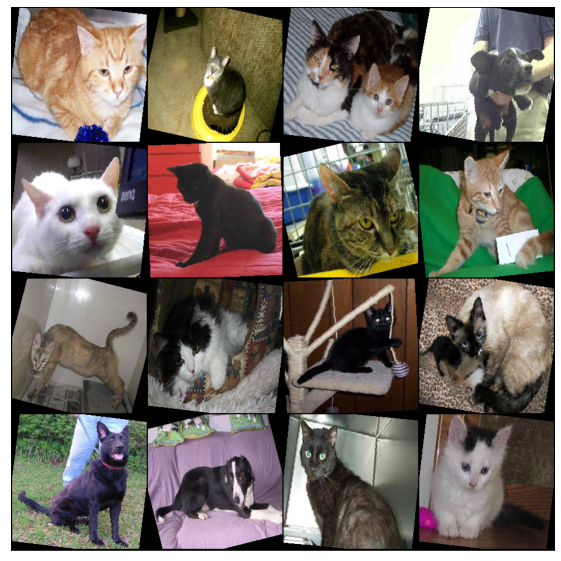

In [10]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
def accuracy(preds, trues):
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [37]:
def train_epoch(train_data_loader):
    
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    for images,labels in train_data_loader:
        
        #loading images and label to the device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0],1))
        
        
        optimizer.zero_grad()   #restart gradients
        
        preds = model(images)
        
        
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)   # calculating accuracy
        
        #Backward
        _loss.backward()
        optimizer.step()
        
        print("training..")
      
    end_time = time.time()
    total_time = end_time - start_time
    
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    #Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
    
    return epoch_loss, epoch_acc, total_time

In [38]:
def val_epoch(val_data_loader, best_val_acc):
    
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    for image,labels in val_data_loader:
        
        #loading images and label to the device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0],1)) #[N,1] match the size with preds
        
        optimizer.zero_grad()   #restart gradients
        
        preds = model(images)   #forward
        
        _loss = criterion(preds, labels)
        loss = _loss.item()     #텐서에 하나의 값만 존재한다면 숫자값을 return
        epoch_loss.append(loss)
        
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)   # calculating accuracy
        
        #Backward
        _loss.backward()
        optimizer.step()
        
    end_time = time.time()
    total_time = end_time - start_time
    
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    #Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    #Saving the best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "model_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

super().__init__()을 사용하는 이유:
예를 들어 자식 클래스가 부모 클래스를 상속받을때, 자식 클래스 내에 부모 클래스의 메소드를 모두 가져오는 것이라고 생각하면 쉽다.

그러나 부모 클래스와 자식 클래스는 모두 __init__() 이라는 메소드를 가지고 있다. 그래서 super()이라는 함수를 쓰지 않으면, 부모 클래스의 init()은 자식 클래스의 init()에 의해서 overwriting된다. 

결론 :  자식 클래스의 init() 메소드에 부모클래스의 init 메소드의 변수를 가지고 오고 싶다. 그래서 자식 클래스에 super를 입력하면 부모 클래스의 init()에 있는 클래스의 변수들을 가져올 수 있다. 

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            
            nn.Conv2d(3, 64, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(256, 512, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(512, 512, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding= 1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
        )
        
        self.avg_pool = nn.AvgPool2d(7)
        self.classifier = nn.Linear(512, 1, bias= True)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 2)
        
    def forward(self, x):
        print(x.shape)
        features = self.conv(x)
        x = self.avg_pool(features)
        x = x.view(features.size(0), -1)
        x = self.classifier(x)
        
        return x, features
        

In [40]:
#model = Net()
model = resnet50(pretrained = True)
model.fc = nn.Sequential(
            nn.Linear(2048, 1, bias = True),
            nn.Sigmoid()
            )
model = model.to(device)
param = list(model.parameters())

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

criterion = nn.BCELoss()

train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

model.to(device)

epochs = 10

In [42]:
best_val_acc = 0
for epoch in range(epochs):
    
    #Training
    loss, acc, _time = train_epoch(train_data_loader)
    
    #Prints details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    #Validation 
    loss, acc, _time, best_val_acc = val_epoch(val_data_loader)
    
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    

training..
training..
training..
training..
training..


KeyboardInterrupt: 